In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Jury selection

In [6]:
panel_size = 100
proportion_black = .26
talladega = pd.DataFrame({'race': ['Black', 'White'], 'proportion': [proportion_black, 1 - proportion_black]})
talladega

,race,proportion
0,Black,0.26
1,White,0.74


This table represents our **null hypothesis**: that the panel is drawn at random from this population with these proportions. Let's try sampling from this null hypothesis.

In [32]:
# sample a jury from the population
panel = talladega.sample(n=panel_size, weights='proportion', replace=True)
# count the number of black jurors
panel.groupby('race').size()

race
Black    26
White    74
dtype: int64

The number of black jurors is our **test statistic**. 

It is often near the proportion in the population (26%), but often is a little higher or lower. We are not seeing any values as low as 8.

In [47]:
# define a function to count number of black jurors on a simulated panel
def count_black_jurors(county):
    panel = county.sample(n=panel_size, weights='proportion', replace=True)
    return panel.groupby('race').size()['Black']

# test the function
count_black_jurors(talladega)

34

<AxesSubplot:ylabel='Density'>

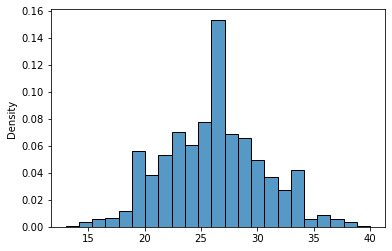

In [56]:
# simulate the jury panel 1000 times
counts = pd.Series([count_black_jurors(talladega) for i in range(1000)])

sns.histplot(counts, stat='density')

This plot shows the **sampling distribution** of the test statistic. 

We see the proportion varies around 26, but 8 is still a very extreme value!

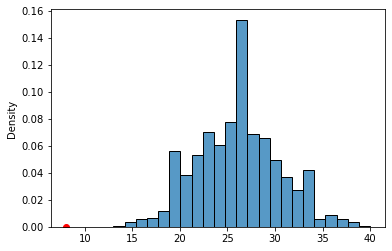

In [57]:
sns.histplot(counts, stat='density')
# add a red dot on the plot at value 8
plt.plot(8, 0, 'ro')

In [74]:
# compute 95% confidence interval using the percentile method
counts.quantile([(1-alpha)/2, alpha + (1-alpha)/2])

0.025    18.0
0.975    35.0
dtype: float64

In [73]:
# compute 95% confidence interval using the normal approximation
alpha = .95
stats.norm.interval(alpha, loc=counts.mean(), scale=counts.std())

(17.535818713780998, 34.688181286219)

# p value

* The probability of getting a result at least as extreme as what we observed, assuming the null hypothesis
* In our example,  the probability of getting a panel with 8 or fewer black jurors if the population proportion is 26%

In [83]:
# compute the p-value using the percentile method
counts[counts <= 8].count() / counts.count()

0.0

In [86]:
# whoops, the counts table contains no values that extreme, 
# so our p-value is 0.0! 
# better simulate more counts, or use the normal approximation
more_counts = pd.Series([count_black_jurors(talladega) for i in range(50000)])

In [87]:
more_counts[more_counts <= 8].count() / more_counts.count()

2e-05

Faster than sampling more: 
* use a normal approximation to the bootstrap distribution
* use the normal cdf to compute the p value

In [82]:
# compute the p-value using the normal approximation
stats.norm.cdf(8, loc=counts.mean(), scale=counts.std())

1.7422957053018457e-05

In [121]:
# equivalently, transform the observation to a z-score and compute the p-value
z = (8 - counts.mean()) / counts.std()
stats.norm.cdf(z)

1.7422957053018457e-05

# Deflategate

Here are the data. Each row corresponds to one football. Pressure is measured in psi. The Patriots ball that had been intercepted by the Colts was not inspected at half-time. Nor were most of the Colts’ balls – the officials simply ran out of time and had to relinquish the balls for the start of second half play.

Pressures were measured by two officials, Clete Blakeman and Dyrol Prioleau.

In [90]:
football = pd.read_csv('data/deflategate.csv')
# football = pd.read_csv('https://raw.githubusercontent.com/stanford-mse-125/demos/main/data/deflategate.csv')
football


,Team,Blakeman,Prioleau
0,Patriots,11.50,11.80
1,Patriots,10.85,11.20
2,Patriots,11.15,11.50
3,Patriots,10.70,11.00
4,Patriots,11.10,11.45
5,Patriots,11.60,11.95
6,Patriots,11.85,12.30
7,Patriots,11.10,11.55
8,Patriots,10.95,11.35
9,Patriots,10.50,10.90


In [91]:
# let's add a column for the average of the officials' measurements
football['avg'] = football[['Blakeman', 'Prioleau']].mean(axis=1)
football

,Team,Blakeman,Prioleau,avg
0,Patriots,11.50,11.80,11.650
1,Patriots,10.85,11.20,11.025
2,Patriots,11.15,11.50,11.325
3,Patriots,10.70,11.00,10.850
4,Patriots,11.10,11.45,11.275
5,Patriots,11.60,11.95,11.775
6,Patriots,11.85,12.30,12.075
7,Patriots,11.10,11.55,11.325
8,Patriots,10.95,11.35,11.150
9,Patriots,10.50,10.90,10.700


It's normal for balls to drop in pressure over time. Did the Patriots' balls deflate more than the Colts' balls?

In [94]:
start_pressure= {'Patriots': 12.5, 'Colts': 13}

In [97]:
# add a column for pressure drop from start of game 
def drop(row):
    return start_pressure[row['Team']] - row['avg']

football['drop'] = football.apply(drop, axis=1)
football

,Team,Blakeman,Prioleau,avg,drop
0,Patriots,11.50,11.80,11.650,0.850
1,Patriots,10.85,11.20,11.025,1.475
2,Patriots,11.15,11.50,11.325,1.175
3,Patriots,10.70,11.00,10.850,1.650
4,Patriots,11.10,11.45,11.275,1.225
5,Patriots,11.60,11.95,11.775,0.725
6,Patriots,11.85,12.30,12.075,0.425
7,Patriots,11.10,11.55,11.325,1.175
8,Patriots,10.95,11.35,11.150,1.350
9,Patriots,10.50,10.90,10.700,1.800


# Poll: whose drops are larger?

* Patriots
* Colts

In [100]:
# average pressure drop for each group 
football.groupby('Team').mean()['drop']

Team
Colts       0.468750
Patriots    1.202273
Name: drop, dtype: float64

# Could this have happened by chance?

* null hypothesis: the 11 Patriots' drops (and the 4 Colts' drops) look like a random sample from all drops
* test statistic: difference in sample means

In [103]:
# compute the observed empirical difference in means
obs = football.groupby('Team').mean()['drop']['Patriots'] - football.groupby('Team').mean()['drop']['Colts']
obs

0.733522727272728

In [105]:
# sample drops at random with replacement
football.sample(n=15, replace=True)['drop']

1     1.475
10    1.375
1     1.475
9     1.800
13    0.275
11    0.475
14    0.650
11    0.475
8     1.350
1     1.475
2     1.175
1     1.475
14    0.650
4     1.225
14    0.650
Name: drop, dtype: float64

In [109]:
# form a simulated data table of Patriots' and Colts' drops under the null 
sim_football = pd.DataFrame({
    'Team': football['Team'],
    'drops': football.sample(n=15, replace=True)['drop'].values
})
sim_football

,Team,drops
0,Patriots,0.850
1,Patriots,1.350
2,Patriots,0.275
3,Patriots,0.475
4,Patriots,1.350
5,Patriots,0.850
6,Patriots,1.375
7,Patriots,1.375
8,Patriots,0.475
9,Patriots,1.225


In [114]:
# write a function to sample the test statistic: difference in means under the null
def simulate_null():
    sim_football = pd.DataFrame({
        'Team': football['Team'],
        'drops': football.sample(n=15, replace=True)['drop'].values
    })
    return sim_football.groupby('Team').mean()['drops']['Patriots'] - sim_football.groupby('Team').mean()['drops']['Colts']

# test the function
simulate_null()

0.4215909090909091

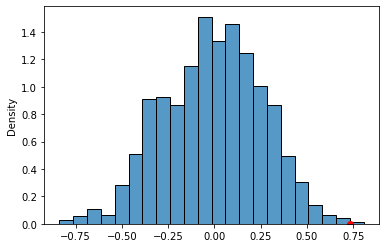

In [116]:
# simulate the test statistic 1000 times
nulls = pd.Series([simulate_null() for i in range(1000)])
# plot the distribution of the test statistic under the null
sns.histplot(nulls, stat='density')
# plot a red dot on the plot at the observed value
plt.plot(obs, 0, 'ro')

In [118]:
# compute the p value using the normal approximation
1-stats.norm.cdf(obs, loc=nulls.mean(), scale=nulls.std())

0.0026999106198294376

In [119]:
# compute the p value using the percentile method
nulls[nulls >= obs].count() / nulls.count()

0.001

# Poll: 

Do you think the Patriots intentionally deflated their balls?
* Yes
* No

# Jellybeans cause acne?

https://xkcd.com/882/

In [130]:
acne_proportion = .2
acne = pd.DataFrame({'outcome': ['Acne', 'No Acne'], 'proportion': [acne_proportion, 1 - acne_proportion]})
acne

,outcome,proportion
0,Acne,0.2
1,No Acne,0.8


In [155]:
# sample 100 patients from the population, randomize to treatment and control
n = 50
treatment = acne.sample(n=n, weights='proportion', replace=True)
control = acne.sample(n=n, weights='proportion', replace=True)
# compute the difference in proportions
obs = treatment.groupby('outcome').size()['Acne'] / n - control.groupby('outcome').size()['Acne'] / n
obs



0.03999999999999998

<AxesSubplot:ylabel='Density'>

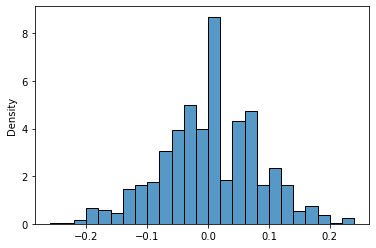

In [156]:
# write a function to simulate the test statistic under the null
def simulate_null():
    treatment = acne.sample(n=n, weights='proportion', replace=True)
    control = acne.sample(n=n, weights='proportion', replace=True)
    return treatment.groupby('outcome').size()['Acne'] / n - control.groupby('outcome').size()['Acne'] / n

# compute the sampling distribution of the test statistic under the null
nulls = pd.Series([simulate_null() for i in range(1000)])

# plot the sampling distribution of the test statistic under the null
sns.histplot(nulls, stat='density')

In [159]:
# now let's run the experiment, for each flavor of jellybean 
flavors = ['cherry', 'orange', 'lemon', 'lime', 'grape', 'strawberry', 'blueberry', 'raspberry', 'blackberry', 'watermelon', 'melon', 'banana', 'apple', 'pineapple', 'peach', 'apricot', 'mango', 'kiwi', 'coconut', 'cantaloupe', 'honeydew', 'cucumber', 'tomato', 'pepper', 'onion', 'garlic', 'ginger', 'cinnamon', 'nutmeg', 'clove', 'vanilla', 'chocolate', 'coffee', 'tea', 'mint', 'lemon', 'lime', 'grape', 'strawberry', 'blueberry', 'raspberry', 'blackberry', 'watermelon']
obs = []
for flavor in flavors:
    # sample patients from the population, randomize to treatment and control
    treatment = acne.sample(n=n, weights='proportion', replace=True)
    control = acne.sample(n=n, weights='proportion', replace=True)
    # compute the observed difference in proportions
    cur_obs = treatment.groupby('outcome').size()['Acne'] / n - control.groupby('outcome').size()['Acne'] / n
    # add the observed difference in proportions to the list
    obs.append(cur_obs)

experiment = pd.DataFrame({'flavor': flavors, 'obs': obs})
experiment

,flavor,obs
0,cherry,0.04
1,orange,0.12
2,lemon,-0.04
3,lime,-0.04
4,grape,-0.06
5,strawberry,-0.14
6,blueberry,-0.04
7,raspberry,0.02
8,blackberry,0.04
9,watermelon,0.18


In [162]:
# let's find the flavor with the largest observed difference in proportions
# compute absolute value of obs 
experiment['abs_obs'] = experiment['obs'].abs()
worst_flavor = experiment.sort_values('abs_obs', ascending=False).head(1)
worst_flavor

,flavor,obs,abs_obs
9,watermelon,0.18,0.18


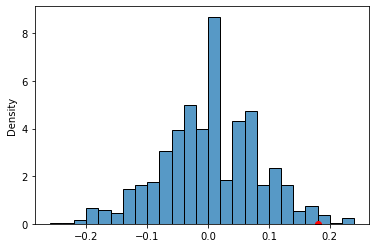

In [165]:
# let's plot it relative to the sampling distribution of the test statistic under the null
sns.histplot(nulls, stat='density')
plt.plot(worst_flavor['obs'], 0, 'ro')

In [167]:
# what's the p-value?
pval = nulls[nulls >= worst_flavor['obs'].values[0]].count() / nulls.count()
pval

0.013

In [169]:
# print the worst flavor and its p value 
print(worst_flavor['flavor'].values[0], 'jellybeans cause acne, with a p-value of', pval)

watermelon jellybeans cause acne, with a p-value of 0.013
